### Koncepcje
Jak kilka osób na Slacku mnie też dopadł problem przestawienia się ze zwykłej analizy danych na time series.
Brakowało mi kolumn w zbiorze testowym na podstawie których mogłem robić predykcję.

Po chwili dotarło do mnie, że tak ma być.
Model działa na wierszach więc musiałem uzupełnić dane dla test.

Proponowana na kursie koncepcja to przesunięcie danych o wymaganą ilość danych do predykcji.
W naszym przypadku było to 24.  
Obcinało to z naszego train 1200 wierszy (50 kawałków po 24h). Na produkcji dane będą bez tych 3-dniowych luk więc problem będzie mniejszy (tylko 24 stracone wiersze).

Zastosowanie tej metody, skali logarytmiczne/zwykłej, średniej z pm25 i odległosci od tej średniej a także .rolling kolumn numerycznych dało mi miejsce ~10 z wynikiem rmse ~17.

Zastosowałem więc inną metodę. Wytrenowałem 24 modele, z których każdy dokonywał predykcji o n godzin do przodu. Np. o 6:00 jeden prognozował 6+1, kolejny 6+2 itd. aż do 6+24.  
Każdy z modeli wykorzystywał cały train poza ostatnim wierszem z każdego bloku. Ten ostatni wiersz (tylko on) służy nam do predykcji 24 kolejnych punktów.  
Tracimy wtedy 50 wierszy. Na produkcji muszę pominąć tylko jeden wiersz.  

Zamiast przesuwać train o 24 wiersze do przodu przesuwamy y o jeden wiersz do tyłu. Trenujemy pierwszy model. Dokonujemy predykcji dla ostatniego wiersza. Uzyskaną wartość wpisujemy do y w lukę powstałą po jej przesunięciu do tyłu. Przesuwamy y o kolejny wiersz, trenujemy kolejny model, robimy predykcję z ostatniego wiersza, dopisujemy do y itd aż do 24 przesunięć.  
Możemy tak zrobić też dla 6, 48 czy 72 wierszy - tyle modeli uzyskamy.

Minusy takiego podejścia:  
- jest konieczność trenowania 24 modeli zamiast jednego - w zależności od parametrów modelu i mocy komputera zajmowało to 1-20 minut
- musimy opierać się o dane wyliczane z modelu, niedokładność będzie się kumulować 
> możemy tego uniknąć używając ostatnie 24 (48, 72) wiersze do walidacji i wyłączyć je ze zbioru treningowego.
- problem z walidacją i krzywymi uczenia (?trzeba podać przesunięty y?)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from ipywidgets import interact
import gc
import pickle
from os import path

np.random.seed(0)

from sklearn.model_selection import KFold, TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, accuracy_score
from ml_metrics import rmse

from scikitplot.estimators import plot_learning_curve

from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def beginFE():
    
    for one in globals().copy().keys():
        if one.endswith('_feats'):
            del globals()[one]
            
    global df, parts, time_feats, black_list_feats, num_feats, omit_feats
    
    train = pd.read_hdf('train_warsaw.h5')
    train = train.rename(columns={'timestamp': 'date'}).reset_index()
    train.drop( columns=['timestamp'], inplace = True)
    test = pd.read_hdf('test_warsaw.h5')
    test = test.rename(columns={'timestamp': 'date'}).reset_index()
    test.drop( columns=['timestamp'], inplace = True)
    
    df = pd.concat([train, test], sort=True)
    df.sort_values(['date', 'id'], inplace=True)
           
    df['hour']    = df.date.dt.hour
    df['day_m']   = df.date.dt.day
    df['month']   = df.date.dt.month
    df['year']    = df.date.dt.year
    df['week_y']  = df.date.dt.week
    df['day_y']   = df.date.dt.dayofyear
    df['day_w']   = df.date.dt.dayofweek
    df['quarter'] = df.date.dt.quarter
    df['hour_w']  = df.date.dt.hour + df.date.dt.dayofweek * 24
    
    df['pm25_log']      = np.log(df[ df['pm25']>0 ]['pm25']+1)
    
    time_feats = ['quarter', 'month', 'week_y', 'day_y', 'day_m', 'day_w', 'hour', 'hour_w', 'year']
    black_list_feats = ['id', 'pm25', 'pm25_log', 'is_non_cont', 'id_dif', 'd_time', 'cont_nr']
    
def endFE():
    
    global train, test, parts, num_feats, omit_feats
    
    # listy kawałków
    def count_cont_nr(flag):
        global value
        if flag:
            value = 1
        else:
            value += 1
        return int(value)
    
    df['is_non_cont'] = df.shift(1).id != (df.id - 1)
    df['id_dif'] = (df.id - df.shift(1).id).fillna(0).astype(int)
    df['d_time'] = df.date - df.shift(1).date
    df.reset_index(drop=True, inplace=True)
    df['cont_nr'] = df.apply(lambda x: count_cont_nr(x['is_non_cont']), axis=1)
    begin_idx = df.loc[df['is_non_cont']].index.values.astype(int)
    end_idx = (df.shift(1).loc[df['is_non_cont']]['cont_nr'].shift(-1) + 
               df.loc[df['is_non_cont']].index.values).values.astype(int)
    end_idx[-1] = int(len(df))
    
    num_feats = df.select_dtypes(include=[np.number, bool]).columns.values
    num_feats = [feat for feat in num_feats if feat not in black_list_feats]
    omit_feats = [x for x in df.columns if x not in num_feats]
            
#     df.fillna(-1, inplace=True)

    parts = []
    for i in range(len(begin_idx)):
        parts.append( df.iloc[ begin_idx[i] : (end_idx[i]) ].copy() )
    train, test = df[ ~df.pm25.isnull() ], df[ df.pm25.isnull() ]
       
def print_feat_groups():   
    feats_list = ['black_list_feats', 'omit_feats', 'num_feats', 'time_feats']
    for one in feats_list:
        if one in globals():
            arr_feats = globals()[one]
            if arr_feats:
                print('--------------------------------------------------')
                print(one, arr_feats)
    print('--------------------------------------------------')

Dodanie .shift(1) przy avg_mov pozwoliło liczyć średnią z przeszłości bez aktualnego pomiaru.  
Jak się okazało dawało to gorsze wyniki.  
Pierwszą koncepcją było liczenie odchylenia od średniej z ostatnich avg_len godzin.  
Miała to być kolumna służąca do predykcji i przeliczenia na 'pm25'.  
Nie zostało to zrealizowane ale kolumny 'avg_mov' i 'avg_diff' zostały.  
Można sprawdzić teorię czy ich wyrzucenie poprawi wynik.  

Drugim pomysłem pogarszającym predykcję było przycięcie wartości 'avg_diff' do zakresu +/- 30 ('cap' / 'no cap').

In [3]:
def feature_engineering_avg(avg_len=24):
    
    beginFE()
    
    df['windSpeed_log'] = (np.log(df[ df['windSpeed']>0 ]['windSpeed']+5))
    df['windGust_log']  = (np.log(df[ df['windGust']>0  ]['windGust']+2))
    
    obj_feats = df.select_dtypes(np.object).columns
    for feat in obj_feats:
        df[feat + '_cat'] = df[feat].factorize()[0]
        
    df['avg_mov'] = df['pm25'].shift(1).rolling( window=avg_len, min_periods=1).mean()
    df['avg_diff'] = df.apply(lambda x: x['pm25']-x['avg_mov'], axis=1)
    
#     df['avg_diff'][df['avg_diff'] > 30] = 30                                   # cap value
#     df['avg_diff'][df['avg_diff'] < -30] = -30
    
    endFE()

    return num_feats, None, parts, df

In [4]:
def feature_engineering_avg_no_shift(avg_len=24):
    
    beginFE()
    
    df['windSpeed_log'] = (np.log(df[ df['windSpeed']>0 ]['windSpeed']+5))
    df['windGust_log']  = (np.log(df[ df['windGust']>0  ]['windGust']+2))
    
    obj_feats = df.select_dtypes(np.object).columns
    for feat in obj_feats:
        df[feat + '_cat'] = df[feat].factorize()[0]
        
    df['avg_mov'] = df['pm25'].rolling( window=avg_len, min_periods=1).mean()
    df['avg_diff'] = df.apply(lambda x: x['pm25']-x['avg_mov'], axis=1)
    
#     df['avg_diff'][df['avg_diff'] > 30] = 30                                   # cap value
#     df['avg_diff'][df['avg_diff'] < -30] = -30
    
    endFE()

    return num_feats, None, parts, df

In [5]:
def feature_engineering_clean():
    
    beginFE()
    
    df['windSpeed_log'] = (np.log(df[ df['windSpeed']>0 ]['windSpeed']+5))
    df['windGust_log']  = (np.log(df[ df['windGust']>0  ]['windGust']+2))
    
    obj_feats = df.select_dtypes(np.object).columns
    for feat in obj_feats:
        df[feat + '_cat'] = df[feat].factorize()[0]
        
#     df['avg_mov'] = df['pm25'].shift(1).rolling( window=avg_len, min_periods=1).mean()
#     df['avg_diff'] = df.apply(lambda x: x['pm25']-x['avg_mov'], axis=1)
    
#     df['avg_diff'][df['avg_diff'] > 30] = 30                                   # cap value
#     df['avg_diff'][df['avg_diff'] < -30] = -30
    
    endFE()

    return num_feats, None, parts, df

In [6]:
def feature_engineering_time():
    
    beginFE()
    
    
    endFE()

    return time_feats, None, parts, df

Kolejna koncepcja - uśrednienie zmiennych numerycznych (poza pochodnymi czasu i kategorialnymi).  
Modyfikacja tego pomysłu dała najlepszy wynik jeśli chodzi o feature_engineering.  
Tworzono kolumny dla róznych okresów .rolling (np. 6, 12) i funkcji ('min', 'max', 'mean', 'median').

In [7]:
def feature_engineering_aggr(avg_len=6):
    
    beginFE()
    
    df['windSpeed_log'] = (np.log(df[ df['windSpeed']>0 ]['windSpeed']+5))
    df['windGust_log']  = (np.log(df[ df['windGust']>0  ]['windGust']+2))
    
    obj_feats = df.select_dtypes(np.object).columns
    for feat in obj_feats:
        df[feat + '_cat'] = df[feat].factorize()[0]
        
    past_feats = df.select_dtypes(include=[np.number, bool]).columns.values
    past_feats = [feat for feat in past_feats if feat not in black_list_feats]
    past_feats = [feat for feat in past_feats if feat not in time_feats]
    
    roll_columns = [feat for feat in past_feats if not feat.endswith('_cat')]   
    roll_nr = [6, 12]
    agr_fn = ['min', 'max', 'mean', 'median']
    for r_feat in roll_columns:
        for fn in agr_fn:
            for nr in roll_nr:    
                suffix = '_roll{}{}'.format(nr, fn)
                df[r_feat + suffix] = getattr(df[r_feat].rolling(nr), fn)()
    roll_feats = [feat for feat in df.columns if '_roll' in feat]
        
    df['avg_mov'] = df['pm25'].shift(1).rolling( window=avg_len, min_periods=1).mean()
    df['avg_diff'] = df.apply(lambda x: x['pm25']-x['avg_mov'], axis=1)
    
#     df['avg_diff'][df['avg_diff'] > 30] = 30                                   # cap value
#     df['avg_diff'][df['avg_diff'] < -30] = -30
    
    endFE()

    return num_feats, None, parts, df

In [8]:
def feature_engineering_aggr_no_shift(avg_len=6):
    
    beginFE()
    
    df['windSpeed_log'] = (np.log(df[ df['windSpeed']>0 ]['windSpeed']+5))
    df['windGust_log']  = (np.log(df[ df['windGust']>0  ]['windGust']+2))
    
    obj_feats = df.select_dtypes(np.object).columns
    for feat in obj_feats:
        df[feat + '_cat'] = df[feat].factorize()[0]
        
    past_feats = df.select_dtypes(include=[np.number, bool]).columns.values
    past_feats = [feat for feat in past_feats if feat not in black_list_feats]
    past_feats = [feat for feat in past_feats if feat not in time_feats]
    
    roll_columns = [feat for feat in past_feats if not feat.endswith('_cat')]   
    roll_nr = [6, 12]
    agr_fn = ['min', 'max', 'mean', 'median']
    for r_feat in roll_columns:
        for fn in agr_fn:
            for nr in roll_nr:    
                suffix = '_roll{}{}'.format(nr, fn)
                df[r_feat + suffix] = getattr(df[r_feat].rolling(nr), fn)()
    roll_feats = [feat for feat in df.columns if '_roll' in feat]
        
    df['avg_mov'] = df['pm25'].rolling( window=avg_len, min_periods=1).mean()
    df['avg_diff'] = df.apply(lambda x: x['pm25']-x['avg_mov'], axis=1)
    
#     df['avg_diff'][df['avg_diff'] > 30] = 30                                   # cap value
#     df['avg_diff'][df['avg_diff'] < -30] = -30
    
    endFE()

    return num_feats, None, parts, df

In [9]:
num_feats, _, parts, df = feature_engineering_time()
feats = num_feats
df.shape, train.shape, test.shape, len(parts), len(feats)

((40152, 36), (38952, 36), (1200, 36), 50, 9)

In [10]:
print_feat_groups()

--------------------------------------------------
black_list_feats ['id', 'pm25', 'pm25_log', 'is_non_cont', 'id_dif', 'd_time', 'cont_nr']
--------------------------------------------------
omit_feats ['date', 'icon', 'id', 'pm25', 'precipType', 'summary', 'pm25_log', 'is_non_cont', 'id_dif', 'd_time', 'cont_nr']
--------------------------------------------------
num_feats ['quarter', 'month', 'week_y', 'day_y', 'day_m', 'day_w', 'hour', 'hour_w', 'year']
--------------------------------------------------
time_feats ['quarter', 'month', 'week_y', 'day_y', 'day_m', 'day_w', 'hour', 'hour_w', 'year']
--------------------------------------------------


In [11]:
def run_model_parts(model, params, parts=parts, feats=feats, y_log=False, cv=None, folds=4, max_train_size=None):
    
    y_test_all, y_pred_all, scores, cv_scores, models = np.array([]), np.array([]), [], [], []

    for x in np.arange(24): 
        models.append(model(**params))
    
    for train in tqdm(parts):                               # kolejne paczki danych train + test(24)
  
        X = train[feats].values
        if y_log:
            y = (train['pm25_log'].values).astype(np.float64)
        else:
            y = (train['pm25'].values).astype(np.float64)      
        X_new = X[-25:-24]                                   # ostatni wiersz train używany do predykcji
            
        for i in np.arange(24):
            y = pd.Series(y).shift(-1).values                # przesunięcie y o jeden w przeszłość
            X_train = X[0:-25]                               # pomija 24+1 
            y_train = y[0:-25]
            
            if cv:
                nr_folds = int((X_train.shape[0] // 24))     # ilość foldów równa ilości dni w paczce
                if folds: nr_folds = folds
                if max_train_size: 
                    cv_local = cv(n_splits=nr_folds, max_train_size=max_train_size)
                else:
                    cv_local = cv(n_splits=nr_folds)
                for train_idx, test_idx in cv_local.split(X_train, y_train):
                    X_fold_train, X_fold_test = X_train[train_idx], X_train[test_idx]
                    y_fold_train, y_fold_test = y_train[train_idx], y_train[test_idx]
                    models[i].fit(X_fold_train, y_fold_train)
                    y_fold_pred = (models[i].predict(X_fold_test))
                    if y_log:
                        y_fold_test = np.exp(y_fold_test)-1
                        y_fold_pred = np.exp(y_fold_pred)-1 
                    cv_scores.append( rmse(y_fold_test, y_fold_pred) )
            else:
                models[i].fit(X_train, y_train)                        
            y_new = (models[i].predict(X_new)).astype(np.float64)   # wyliczanie y dla ostatniego wiersza            
            y[-25] = y_new[0]                                       # zapisanie w luce
        
        y_test = y[-73:-49]     # dane z ostatniego dnia train
                                # używane do wątpliwej walidacji - porównuje ostatni dzień train z predykcja
        y_pred = y[-49:-25]     # tu błąd powinno być y[-48:-24], pobierał jedną daną real, pomijał ostatnią z predykcji
                                # tu mamy naszą prognozę na kolejne 24h
        if y_log:
            y_test = np.exp(y_test)-1
            y_pred = np.exp(y_pred)-1
        
        scores.append(rmse(y_test, y_pred))
        y_test_all = np.concatenate((y_test_all, y_test))
        y_pred_all = np.concatenate((y_pred_all, y_pred))    
    
#     print("part scores", np.mean(scores), np.std(scores))
#     if len(cv_scores)>0: 
#         print("\nCV scores", np.mean(cv_scores), np.std(cv_scores))
#     score = "global rmse, mae, r2", rmse(y_test_all, y_pred_all), mean_absolute_error(y_test_all, y_pred_all), \
#                             r2_score(y_test_all, y_pred_all)
#     print(score)
#     
#     print('CV: {}, folds: {}, logaritm: {}, \nmodel: {}, \nparams: {}'.format(cv, folds, y_log, model, params))
       
    return(models, y_test_all, y_pred_all, scores)

In [12]:
# walidacja modeli w oparciu o shift i zgodność predykcji z wartościami train
# każdy model generuje krzywą przesuniętą o n godzin
# sprawdzamy jakie przesunięcie modelu daje najniższy błąd train do pred
# sprawdzamy 2-3 przesunięcia względem numeru modelu
# problemem tej walidacji były osiągane przy hyperopt bardzo niskie wartości rmse - nawet 0.0001
# nie gwarantowała też rankingu zgodnego z Kagglem.
# wszystkie wartości 'best_shifts' powinny być równe, złe modele miały jedną wartość przesuniętą (np. z 4 na 5)

def validate_model(name, log_y, long = 1200, side=3):
    with open(name, 'rb') as f:
        result = pickle.load(f)
    if len(result) == 4:
        models, y_test_all, y_pred_all, scores = result
    if len(result) == 9:
        global_scores, last_day_scores, models, y_pred_all, train_df, last_days_df, y_train_all, y_last_days, y_last_pred \
            = result  
    g_scores = np.array([])
    best_shifts = []
    for i in tqdm(np.arange(24)):
        model = models[i]
        scores = np.array([])
        for shift in np.arange(-i-side, -i+side):
            X = train[feats].values
            y = train['pm25'].values
            y = pd.Series(y).shift(shift).values
            y_pred = (model.predict(X)).astype(np.float64)
            if log_y: 
                y_pred = np.exp(y_pred)-1
            if shift >= 0: 
                scores = np.append( scores, [rmse(y[-long:], y_pred[-long:])] )
    #             print(shift, rmse(y[-long:], y_pred[-long:]), len(y[-long:]), len(y_pred[-long:]))
            else: 
                scores = np.append( scores, [rmse(y[-long:shift], y_pred[-long:shift])] )
    #             print(shift, rmse(y[-long:shift], y_pred[-long:shift]), len(y[-long:shift]), len(y_pred[-long:shift]))
        print (scores[scores.argmin()])
        g_scores = np.append( g_scores, [scores[scores.argmin()]] )
        best_shifts.append(scores.argmin())
    return g_scores, best_shifts

In [13]:
# wersja pokazująca jedną wartość na model
def validate_model2(name, log_y, long = 1200):
    with open(name, 'rb') as f:
        result = pickle.load(f)
    if len(result) == 4:
        models, y_test_all, y_pred_all, scores = result
    if len(result) == 9:
        global_scores, last_day_scores, models, y_pred_all, train_df, last_days_df, y_train_all, y_last_days, y_last_pred \
            = result  
    g_scores = np.array([])
    for i in tqdm(np.arange(24)):
        model = models[i]
        X = train[feats].values
        y = train['pm25'].values
        y = pd.Series(y).shift(-i-1).values
        y_pred = (model.predict(X)).astype(np.float64)
        if log_y: 
            y_pred = np.exp(y_pred)-1
        g_scores = np.append( g_scores, [rmse(y[-long:-i-1], y_pred[-long:-i-1])] )
        print(g_scores[-1], len(y[-long:-i-1]), len(y_pred[-long:-i-1]))
    return g_scores

In [ ]:
result_files = ['avg_1.p', 'avg_2.p', 'avg_3.p', 'avg_4.p', 'avg_5.p', 'avg_6.p', 'avg_7.p', 'avg_8.p', 'avg_9.p', 
                'avg_10.p', 'avg_11.p', 'avg_12.p', 'avg_13.p', 'avg_14.p']
side = 3
for i in tqdm(np.arange(24)):
    best = 1000
    best_nr = 1000
    for file in result_files:
        with open(file, 'rb') as f:
            models, y_test_all, y_pred_all, scores = pickle.load(f)
        with open('df_'+file, 'rb') as f_df:
            feats, parts, df, log_y = pickle.load(f_df)
        train = df[ ~df.pm25.isnull() ]
        scores = np.array([])
        model = models[i]
        for shift in np.arange(-i-side, -i+side):
            X = train[feats].values
            y = train['pm25'].values
            y = pd.Series(y).shift(shift).values
            y_pred = (model.predict(X)).astype(np.float64)
            if log_y: 
                y_pred = np.exp(y_pred)-1
            if shift >= 0: 
                scores = np.append( scores, [rmse(y[-long:], y_pred[-long:])] )
            else: 
                scores = np.append( scores, [rmse(y[-long:shift], y_pred[-long:shift])] )
        val_min = scores[scores.argmin()]
        if val_min < best:
            best = val_min
            best_nr = scores.argmin()
    print(i, file, best_nr, best)

ponieważ predykcja z gotowego modelu dawała wyniki zbliżone do średniej próbowałem uwzględnic korektę predykcji na podstawie przedostatniego wyniku - efekty lepsze niż bez tego ale dużo gorsze niż predykcja cząstkowa po każdym .fit

In [14]:
# bez korekty

def simple_predict(name, log_y, shift, parts):
    with open(name, 'rb') as f:
        result = pickle.load(f)
    if len(result) == 4:
        models, y_test_all, y_pred_all, scores = result
    if len(result) == 9:
        global_scores, last_day_scores, models, y_pred_all, train_df, last_days_df, y_train_all, y_last_days, y_last_pred \
            = result    
    y_pred = np.array([])
    for part in parts:
        X = part[feats].values
        X_last_row = X[-shift-1:-shift]
        for m in models:
            y_hour = (m.predict(X_last_row)).astype(np.float64)
            if log_y: 
                y_hour = np.exp(y_hour)-1
            y_pred = np.append(y_pred, y_hour)
    return y_pred

In [15]:
# korekta dla przedostatniego wiersza i pierwszego modelu

def make_predict(name, log_y, shift, parts):
    with open(name, 'rb') as f:
        result = pickle.load(f)
    if len(result) == 4:
        models, y_test_all, y_pred_all, scores = result
    if len(result) == 9:
        global_scores, last_day_scores, models, y_pred_all, train_df, last_days_df, y_train_all, y_last_days, y_last_pred \
            = result    
    y_pred = np.array([])
    for part in parts:
        X = part[feats].values
        y = part['pm25'].values
        X_last_row = X[-shift-1:-shift]
        y_last_row = y[-shift-1:-shift]
        X_pre_last_row = X[-shift-2:-shift-1]
        y_pre_last_pred = (models[0].predict(X_pre_last_row)).astype(np.float64)
        if log_y: 
                y_pre_last_pred = np.exp(y_pre_last_pred)-1
        correction = y_last_row - y_pre_last_pred
        for m in models:
            y_hour = (m.predict(X_last_row)).astype(np.float64)
            if log_y: 
                y_hour = np.exp(y_hour)-1
            y_pred = np.append(y_pred, [y_hour + correction])
    return y_pred

In [16]:
# podobnie jak poprzednio ale używa do korekty kolejnych wierszy dla kolejnych modeli zamiast przedostatniego wiersza

def make_predict2(name, log_y, shift, parts):
    with open(name, 'rb') as f:
        result = pickle.load(f)
    if len(result) == 4:
        models, y_test_all, y_pred_all, scores = result
    if len(result) == 9:
        global_scores, last_day_scores, models, y_pred_all, train_df, last_days_df, y_train_all, y_last_days, y_last_pred \
            = result
    y_pred = np.array([])
    for part in parts:
        X = part[feats].values
        y = part['pm25'].values
        X_last_row = X[-shift-1:-shift]
        y_last_row = y[-shift-1:-shift]
        X_pre_last_row = X[-shift-2:-shift-1]
        for i in np.arange(24):
            X_pre_last_row = X[-shift-2-i:-shift-1-i]
            y_pre_last_pred = (models[i].predict(X_pre_last_row)).astype(np.float64)
            if log_y: 
                y_pre_last_pred = np.exp(y_pre_last_pred)-1
            correction = y_last_row - y_pre_last_pred
            y_hour = (models[i].predict(X_last_row)).astype(np.float64)
            if log_y: 
                y_hour = np.exp(y_hour)-1
            y_pred = np.append(y_pred, [y_hour + correction])
    return y_pred

In [17]:
# walidacja wg ostatniego dnia każdej części z korektą j.w.

def val_last_day(name, log_y):
    with open(name, 'rb') as f:
        result = pickle.load(f)
    if len(result) == 4:
        models, y_test_all, y_pred_all, scores = result
    if len(result) == 9:
        global_scores, last_day_scores, models, y_pred_all, train_df, last_days_df, y_train_all, y_last_days, y_last_pred \
            = result     
    y_real, y_pred = np.array([]), np.array([])
    for part in parts:
        X = part[feats].values
        y = part['pm25'].values
        y_last_day = y[-48:-24]
        X_last_row = X[-49:-48]
        y_last_row = y[-49:-48]
        X_pre_last_row = X[-50:-49]
        y_last_row_pred = (models[0].predict(X_pre_last_row)).astype(np.float64)
        if log_y: 
                y_last_row_pred = np.exp(y_last_row_pred)-1
        correction = y_last_row - y_last_row_pred
        for m in models:
            y_hour_pred = (m.predict(X_last_row)).astype(np.float64)
            if log_y: 
                y_hour_pred = np.exp(y_hour_pred)-1            
            y_pred = np.append(y_pred, y_hour_pred + correction)
        y_real = np.append(y_real, y_last_day)
#     print(y_real.shape, y_pred.shape, rmse(y_real, y_pred))
    return rmse(y_real, y_pred)

In [18]:
def simple_predict_last(name, log_y, parts):
    with open(name, 'rb') as f:
        result = pickle.load(f)
    if len(result) == 4:
        models, y_test_all, y_pred_all, scores = result
    if len(result) == 9:
        global_scores, last_day_scores, models, y_pred_all, train_df, last_days_df, y_train_all, y_last_days, y_last_pred \
            = result
    y_pred = np.array([])
    for part in parts:
        X = part[feats].values
        X_pre = X[-49:-48]
        for m in models:
            y_hour = (m.predict(X_pre)).astype(np.float64)
            if log_y: 
                y_hour = np.exp(y_hour)-1
            y_pred = np.append(y_pred, y_hour)
    return y_pred

### Po wytrenowaniu modelu można ocenić wizualnie walidację dla ostatniego dnia

In [19]:
name = 'avg_10.p'
with open(name, 'rb') as f:
    models, y_test_all, y_pred_all, scores = pickle.load(f)
# with open('df_'+name, 'rb') as f:
#     feats, parts, df, log_y = pickle.load(f)
feats, _, parts, df = feature_engineering_avg_no_shift()
nr=0

### walidacja ostatniego dnia, predykcja z finalnego modelu z uwzględnieniem korekty na ostatni wiersz train

In [20]:
@interact(part_nr=(0, 49))

def final_correction(part_nr=0, log_y = False):
    y_pred = np.array([])
    y_no_corr = np.array([])
    X = parts[part_nr][feats].values
    y = parts[part_nr]['pm25'].values
    y_last_day = y[-48:-24]
    y_real = y[-72:-24]
    X_last_row = X[-49:-48]
    y_last_row = y[-49:-48]
    X_pre_last_row = X[-50:-49]
    y_last_row_pred = (models[0].predict(X_pre_last_row)).astype(np.float64)
    if log_y: 
            y_last_row_pred = np.exp(y_last_row_pred)-1
    correction = y_last_row - y_last_row_pred
    for m in models:
        y_hour_pred = (m.predict(X_last_row)).astype(np.float64)
        if log_y: 
            y_hour_pred = np.exp(y_hour_pred)-1
        y_pred = np.append(y_pred, y_hour_pred + correction)
        y_no_corr = np.append(y_no_corr, y_hour_pred)
    print(rmse(y_last_day, y_pred), rmse(y_last_day, y_no_corr))
    
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(24)+24, y_no_corr, label='no_corr', c='lime');
    plt.plot(np.arange(24)+24, y_pred, label='corr', c='red');
    plt.plot(np.arange(48), y_real, label='real', c='blue');
    plt.legend();

interactive(children=(IntSlider(value=0, description='part_nr', max=49), Checkbox(value=False, description='lo…

### porównanie predykcji z test i  ostatniego dnia - "walidacja" dyskusyjna

In [21]:
def insert_every_day(y, part_size=24, insert_size=24):
    result = np.array([])
    insert = np.array( [np.nan]*insert_size )
    for one in np.arange(0, len(y-part_size), part_size):
        result = np.append( result, y[one:one+part_size])
        result = np.append( result, insert)
    return result

In [22]:
name = 'avg_16.p'
name_best = 'avg_15.p'

feats, _, parts, df = feature_engineering_avg_no_shift()
    
with open(name, 'rb') as f:
    models, y_test_all, y_pred_all, scores = pickle.load(f)

with open(name_best, 'rb') as f:
    models2, y_test_all2, y_pred_all2, scores2 = pickle.load(f)

In [23]:
@interact()

def all_test(log_y = False, real=True, pred=True, best=True, final1=False, final2=False, no_corr=False):

    # cały test - predykcja cząstkowa 
    # porównanie predykcji najlepszego modelu z aktualnym i dniem poprzedzajacym
    # predykcje z modelu końcowego skorygowanego i zwykłego

    y_final = make_predict(name, log_y, 48, parts)
    y_final2 = make_predict2(name, log_y, 48, parts)
    y_no_corr = simple_predict(name, log_y, 48, parts)

    y_test_all_ = insert_every_day(y_test_all)
    y_pred_all_ = insert_every_day(y_pred_all)
    y_pred_all2_ = insert_every_day(y_pred_all2)
    y_final_ = insert_every_day(y_final)
    y_final2_ = insert_every_day(y_final2)
    y_no_corr_ = insert_every_day(y_no_corr)
    
    plt.figure(figsize=(20,10))
    if real: plt.plot(np.arange(len(y_test_all_)), y_test_all_, label='real', c='blue');
    if pred: plt.plot(np.arange(len(y_pred_all_))+24, y_pred_all_, label='pred', c='red');
    if best: plt.plot(np.arange(len(y_pred_all2_))+24, y_pred_all2_, label='best', c='lime');
    if final1: plt.plot(np.arange(len(y_final_))+24, y_final_, label='final1', c='orange');
    if final2: plt.plot(np.arange(len(y_final2_))+24, y_final2_, label='final2', c='gray');
    if no_corr: plt.plot(np.arange(len(y_no_corr_))+24, y_no_corr_, label='final2', c='black');
    plt.legend()
    plt.show
    print('pred: {:.3f} pred_best: {:.3f} final1: {:.3f} final2: {:.3f} no_corr: {:.3f}'.format(
        rmse(y_test_all, y_pred_all), 
        rmse(y_test_all2, y_pred_all2), 
        rmse(y_test_all, y_final),
        rmse(y_test_all, y_final2),
        rmse(y_test_all, y_no_corr)
         ))

interactive(children=(Checkbox(value=False, description='log_y'), Checkbox(value=True, description='real'), Ch…

### pojedyńczy blok i początek nastepnego + porównanie dwóch modeli

In [24]:
name = 'avg_16.p'
name_best = 'avg_15.p'

feats, _, parts, df = feature_engineering_avg_no_shift()
    
with open(name, 'rb') as f:
    models, y_test_all, y_pred_all, scores = pickle.load(f)

with open(name_best, 'rb') as f:
    models2, y_test_all2, y_pred_all2, scores2 = pickle.load(f)

In [25]:
@interact(part_nr=(0, 49))

def partial_comparison(part_nr=0, log_y = False, real=True, pred=True, best=True, final1=False, final2=False, no_corr=False):
    long = 24
    y_train_real = parts[part_nr][:-24]['pm25']
    
    y_final = make_predict(name, log_y, 24, parts)
    y_final2 = make_predict2(name, log_y, 24, parts)
    y_no_corr = simple_predict(name, log_y, 24, parts)
    
    idx = part_nr*24
    y_pred = y_pred_all[idx:idx+24]
    y_pred2 = y_pred_all2[idx:idx+24]
    y_fin = y_final[idx:idx+24]
    y_fin2 = y_final2[idx:idx+24]
    y_no_co = y_no_corr[idx:idx+24]
    
#     y_test = y_test_all[idx:idx+24]
    plt.figure(figsize=(20,10))
    if real: plt.plot(np.arange(long), y_train_real[-long:], label='real', c='blue');
    if pred: plt.plot(np.arange(24)+long, y_pred, label='pred', c='red');
    if best: plt.plot(np.arange(24)+long, y_pred2, label='best', c='lime');
    if final1: plt.plot(np.arange(24)+long, y_fin, label='final', c='orange');
    if final2: plt.plot(np.arange(24)+long, y_fin2, label='final2', c='gray');
    if no_corr: plt.plot(np.arange(24)+long, y_no_co, label='no corr', c='black');
    
    if part_nr<(len(parts)-1):
        y_next = parts[part_nr+1][:24]['pm25']
        if real: plt.plot(np.arange(24)+long+24+24, y_next, c='blue');
    plt.legend();
    print(part_nr, parts[part_nr][0:1]['id'].values, scores[part_nr])

interactive(children=(IntSlider(value=0, description='part_nr', max=49), Checkbox(value=False, description='lo…

### Ocena shift walidacji

In [26]:
with open('avg_4.p', 'rb') as f:
    models, y_test_all, y_pred_all, scores = pickle.load(f)

In [27]:
@interact(model_nr=(0, len(models)-1), shift=(-30, 30))

def partial_comparison(model_nr=7, shift=-8, log_y = True):
    long = 72
    back = 10000
    model = models[model_nr]
    X = train[feats].values
    y = train['pm25'].values
    y = pd.Series(y).shift(shift).values
    y_pred = (model.predict(X)).astype(np.float64)
    if log_y: y_pred = np.exp(y_pred)-1
    plt.figure(figsize=(20,10))
    
    if shift >= 0: 
        print(nr, shift, rmse(y[-long-back:-back], y_pred[-long-back:-back]))
        plt.plot(np.arange(long), y[-long-back:-back], label='real', c='blue');
        plt.plot(np.arange(long), y_pred[-long-back:-back], label='pred', c='red');
    else: 
        print(nr, shift, rmse(y[-long-back:shift-back], y_pred[-long-back:shift-back]))
        plt.plot(np.arange(long), y[-long+shift-back:shift-back], label='real', c='blue');
        plt.plot(np.arange(long), y_pred[-long+shift-back:shift-back], label='pred', c='red');
        
    plt.legend()
    plt.show;

interactive(children=(IntSlider(value=7, description='model_nr', max=23), IntSlider(value=-8, description='shi…

In [28]:
@interact(model_nr=(0, len(models)-1), add=(-24, 24))

def partial_comparison(model_nr=0, add=-1, log_y = True):
    long = 72
    back = 10000
    shift = -model_nr+add
    model = models[model_nr]
    X = train[feats].values
    y = train['pm25'].values
    y = pd.Series(y).shift(shift).values
    y_pred = (model.predict(X)).astype(np.float64)
    if log_y: y_pred = np.exp(y_pred)-1
    plt.figure(figsize=(20,10))
    
    print(model_nr, rmse(y[-long-back:shift-back], y_pred[-long-back:shift-back]))
    plt.plot(np.arange(long), y[-long+shift-back:shift-back], label='real', c='blue');
    plt.plot(np.arange(long), y_pred[-long+shift-back:shift-back], label='pred', c='red');
        
    plt.legend()
    plt.show;

interactive(children=(IntSlider(value=0, description='model_nr', max=23), IntSlider(value=-1, description='add…

### walidacja shift score - porównanie dwóch modeli, im niżej tym lepiej

('mean diff', -0.8936535139787821)

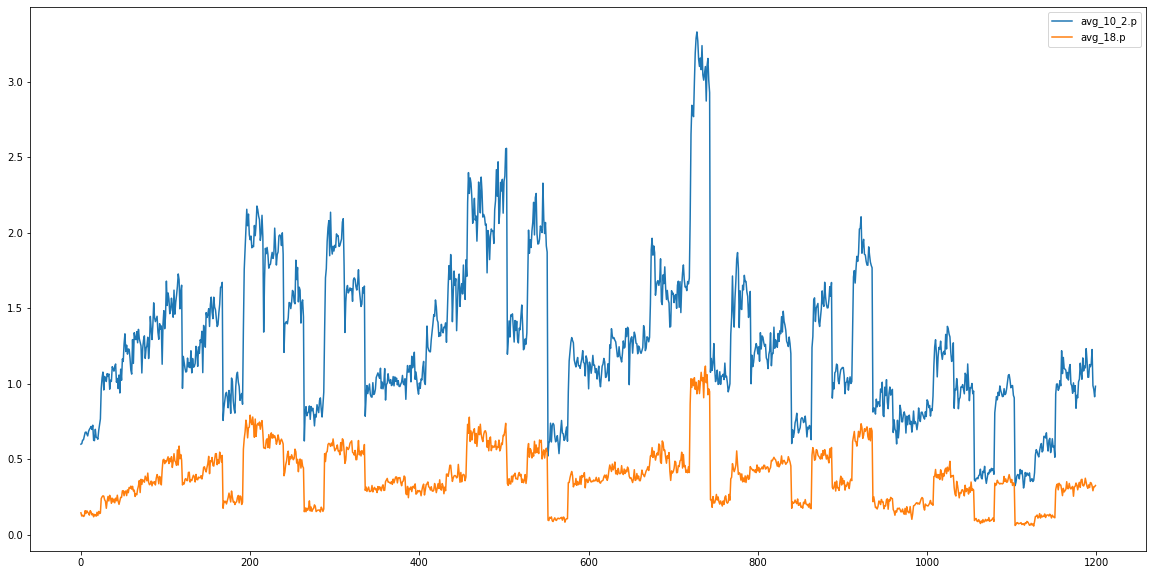

In [29]:
name = 'avg_10_2.p'
name2 = 'avg_18.p'

with open(name, 'rb') as f:
    global_scores, last_day_scores, models, y_pred_all, train_df, last_days_df, y_train_all, y_last_days, y_last_pred = \
        pickle.load(f)

with open(name2, 'rb') as f:
    global_scores2, last_day_scores2, models2, y_pred_all2, train_df2, last_days_df2, y_train_all2, \
        y_last_days2, y_last_pred2 = pickle.load(f)
    
plt.figure(figsize=(20,10))
plt.plot(global_scores, label=name)
plt.plot(global_scores2, label=name2)
plt.legend();
'mean diff', (global_scores2 - global_scores).mean()

### walidacja wg ostatniego dnia - porównanie modeli

('mean diff', 0.24823630095140164)

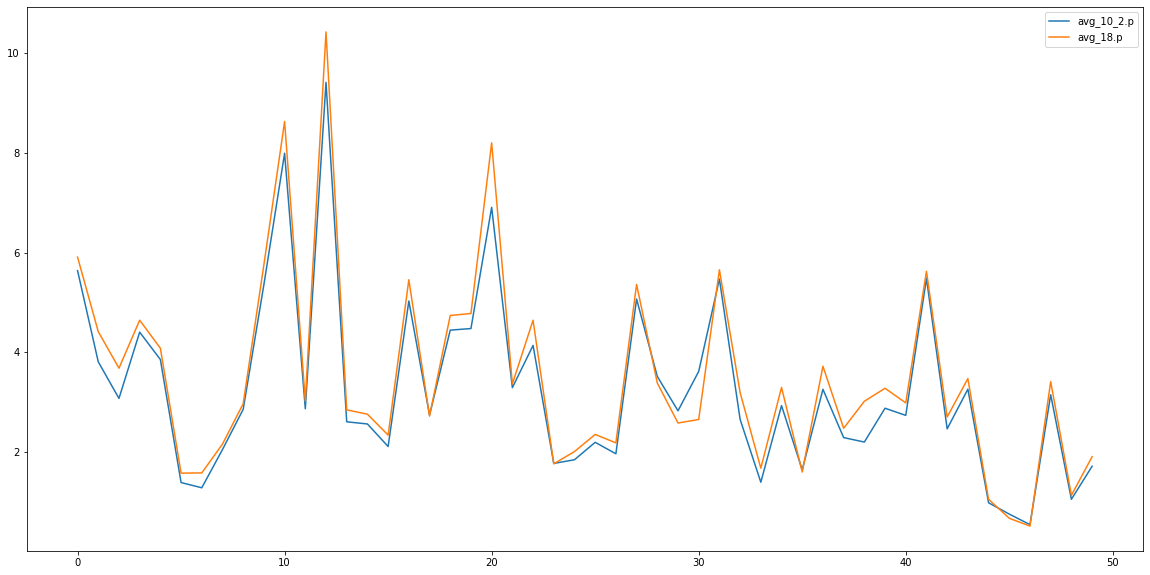

In [30]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(50), last_day_scores, label=name)
plt.plot(np.arange(50), last_day_scores2, label=name2)
plt.legend();
'mean diff', (last_day_scores2 - last_day_scores).mean()

### predykcja z finalnych modeli - dużo gorsze wyniki

In [31]:
name = 'avg_15.p'           # 14.85382 13.77642    vs    16.54333 15.44674
log_y = False
y_final = make_predict(name, log_y, 24, parts)
# test['pm25'] = y_final
# test[ ['id', 'pm25'] ].to_csv('submit_final_{}.csv'.format(name[:-2]), index=False)

In [32]:
name = 'avg_15.p'           # 14.85382 13.77642    vs    17.15519 17.52971
log_y = False
y_final = make_predict2(name, log_y, 24, parts)
# test['pm25'] = y_final
# test[ ['id', 'pm25'] ].to_csv('submit_final2_{}.csv'.format(name[:-2]), index=False)

### Parametry poszczególnych modeli, generowanie submitu i walidacja

In [ ]:
%%time
name = 'avg_6.p'
log_y = False
feats, _, parts, df = feature_engineering_clean()

print(df.shape, train.shape, test.shape, len(parts), len(feats))
with_params = {
    'model'         : xgb.XGBRegressor,
    'params'        : {'n_jobs': 8,
                       'random_state': 123,
                       'objective': 'reg:squarederror',    #reg:squarederror reg:linear
                       'max_depth': 5,
                       'subsample': 0.95},
    'parts'         : parts, 
    'feats'         : feats,
    'y_log'         : log_y,
    'cv'            : None,
    'folds'         : 0,
    'max_train_size': None,
}
models, y_test_all, y_pred_all, scores = run_model_parts(**with_params)
result = models, y_test_all, y_pred_all, scores
with open(name, 'wb') as f:
    pickle.dump(result, f)
# test['pm25'] = y_pred_all
# test[ ['id', 'pm25'] ].to_csv('submit_{}.csv'.format(name[:-2]), index=False)

In [34]:
name = 'avg_6.p'
log_y = False
feats, _, parts, df = feature_engineering_clean()
print(val_last_day(name, log_y))
g_scores, best_shifts = validate_model(name, log_y=log_y)
print(g_scores.mean(), g_scores.std())
print(best_shifts)

13.649912193370831


4.973205801491224
4.97882757502455
4.830530360846448
4.945149287548374
5.0074108901023315
4.784640518929028
4.6834002979016836
4.331295672070178
4.449494834987302
4.80828889347324
4.67943634741107
4.6010601981166745
4.966089287150607
4.94871333114752
5.027543444699087
5.076846874199069
4.964803079324515
5.435222344955926
5.092443123805792
5.436048034318327
5.390204620651023
5.527547516671241
5.463811167837882
5.19437061929692

4.983182671748334 0.3099003631471278
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [1172]:
%%time
name = 'avg_7.p'
log_y = True
feats, _, parts, df = feature_engineering_clean()
print(df.shape, train.shape, test.shape, len(parts), len(feats))
with_params = {
    'model'         : xgb.XGBRegressor,
    'params'        : {'n_jobs': 8,
                       'random_state': 123,
                       'objective': 'reg:squarederror',    #reg:squarederror reg:linear
                       'max_depth': 5,
                       'subsample': 0.95},
    'parts'         : parts, 
    'feats'         : feats,
    'y_log'         : log_y,
    'cv'            : None,
    'folds'         : 0,
    'max_train_size': None,
}
models, y_test_all, y_pred_all, scores = run_model_parts(**with_params)
result = models, y_test_all, y_pred_all, scores
with open(name, 'wb') as f:
    pickle.dump(result, f)
test['pm25'] = y_pred_all
test[ ['id', 'pm25'] ].to_csv('submit_{}.csv'.format(name[:-2]), index=False)

(40152, 41) (38952, 41) (1200, 41) 50 30



part scores 9.094960879433156 6.140643606824406
('\nglobal rmse, mae, r2', 10.97386975066011, 7.476507768045581, 0.6561018631315367)
CV: None, folds: 0, logaritm: True, 
model: <class 'xgboost.sklearn.XGBRegressor'>, 
params: {'n_jobs': 8, 'random_state': 123, 'objective': 'reg:squarederror', 'max_depth': 5, 'subsample': 0.95}
Wall time: 4min 31s


In [2023]:
name = 'avg_7.p'
log_y = True
feats, _, parts, df = feature_engineering_clean()
print(val_last_day(name, log_y))
g_scores, best_shifts = validate_model(name, log_y=log_y)
print(g_scores.mean(), g_scores.std())
print(best_shifts)

13.45528164063174



5.207241987678015 0.3012736382748538
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [1267]:
%%time
name = 'avg_8.p'
log_y = False
feats, _, parts, df = feature_engineering_time()
print(df.shape, train.shape, test.shape, len(parts), len(feats))
with_params = {
    'model'         : xgb.XGBRegressor,
    'params'        : {'n_jobs': 8,
                       'random_state': 123,
                       'objective': 'reg:squarederror',    #reg:squarederror reg:linear
                       'max_depth': 5,
                       'subsample': 0.95},
    'parts'         : parts, 
    'feats'         : feats,
    'y_log'         : log_y,
    'cv'            : None,
    'folds'         : 0,
    'max_train_size': None,
}
models, y_test_all, y_pred_all, scores = run_model_parts(**with_params)
result = models, y_test_all, y_pred_all, scores
with open(name, 'wb') as f:
    pickle.dump(result, f)
test['pm25'] = y_pred_all
test[ ['id', 'pm25'] ].to_csv('submit_{}.csv'.format(name[:-2]), index=False)

(40152, 36) (38952, 36) (1200, 36) 50 9



part scores 8.547176693858725 6.403877078276574
('\nglobal rmse, mae, r2', 10.68006887008309, 7.0683772435921215, 0.6742695742250104)
CV: None, folds: 0, logaritm: False, 
model: <class 'xgboost.sklearn.XGBRegressor'>, 
params: {'n_jobs': 8, 'random_state': 123, 'objective': 'reg:squarederror', 'max_depth': 5, 'subsample': 0.95}
Wall time: 3min 41s


In [2024]:
name = 'avg_8.p'
log_y = False
feats, _, parts, df = feature_engineering_time()
print(val_last_day(name, log_y))
g_scores, best_shifts = validate_model(name, log_y=log_y)
print(g_scores.mean(), g_scores.std())
print(best_shifts)

14.581993172416514



6.368753104209304 0.266013938360076
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [1322]:
%%time
name = 'avg_9.p'
log_y = True
feats, _, parts, df = feature_engineering_time()
print(df.shape, train.shape, test.shape, len(parts), len(feats))
with_params = {
    'model'         : xgb.XGBRegressor,
    'params'        : {'n_jobs': 8,
                       'random_state': 123,
                       'objective': 'reg:squarederror',    #reg:squarederror reg:linear
                       'max_depth': 5,
                       'subsample': 0.95},
    'parts'         : parts, 
    'feats'         : feats,
    'y_log'         : log_y,
    'cv'            : None,
    'folds'         : 0,
    'max_train_size': None,
}
models, y_test_all, y_pred_all, scores = run_model_parts(**with_params)
result = models, y_test_all, y_pred_all, scores
with open(name, 'wb') as f:
    pickle.dump(result, f)
test['pm25'] = y_pred_all
test[ ['id', 'pm25'] ].to_csv('submit_{}.csv'.format(name[:-2]), index=False)

(40152, 36) (38952, 36) (1200, 36) 50 9



part scores 8.428134315904128 6.940778184568551
('\nglobal rmse, mae, r2', 10.918234740758392, 6.959143795113084, 0.659579993870014)
CV: None, folds: 0, logaritm: True, 
model: <class 'xgboost.sklearn.XGBRegressor'>, 
params: {'n_jobs': 8, 'random_state': 123, 'objective': 'reg:squarederror', 'max_depth': 5, 'subsample': 0.95}
Wall time: 3min 35s


In [2025]:
name = 'avg_9.p'
log_y = True
feats, _, parts, df = feature_engineering_time()
print(val_last_day(name, log_y))
g_scores, best_shifts = validate_model(name, log_y=log_y)
print(g_scores.mean(), g_scores.std())
print(best_shifts)

13.598247395990025



6.6618609027345626 0.16457763108115253
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [26]:
%%time
name = 'avg_10.p'
log_y = False
feats, _, parts, df = feature_engineering_avg_no_shift()
print(df.shape, train.shape, test.shape, len(parts), len(feats))
with_params = {
    'model'         : xgb.XGBRegressor,
    'params'        : {'n_jobs': 8,
                       'random_state': 123,
                       'objective': 'reg:squarederror',    #reg:squarederror reg:linear
                       'max_depth': 5,
                       'subsample': 0.95},
    'parts'         : parts, 
    'feats'         : feats,
    'y_log'         : log_y,
    'cv'            : None,
    'folds'         : 0,
    'max_train_size': None,
}
models, y_test_all, y_pred_all, scores = run_model_parts(**with_params)
# result = models, y_test_all, y_pred_all, scores
# with open(name, 'wb') as f:
#     pickle.dump(result, f)
# test['pm25'] = y_pred_all
# test[ ['id', 'pm25'] ].to_csv('submit_{}.csv'.format(name[:-2]), index=False)

(40152, 43) (38952, 43) (1200, 43) 50 32



Wall time: 4min 42s


In [47]:
name = 'avg_10.p'
log_y = False
feats, _, parts, df = feature_engineering_avg_no_shift()
print(val_last_day(name, log_y))
g_scores, best_shifts = validate_model(name, log_y=log_y)
print(g_scores.mean(), g_scores.std())
print(best_shifts)

14.64286287210863


1.9983824539307156
3.1443833520407725
3.7634066956335865
4.028262718725387
4.482619483924713
4.487420756658131
4.546313831147509
4.35886023717557
4.45044027297689
4.547429170662017
4.985979511847225
4.721519954576131
4.649467154090587
4.611337798519143
4.686647343390142
4.921658213618609
4.843264710889962
5.499884074172952
5.576869825693665
5.524713720289542
5.332447322864877
5.602560976071546
5.608694669426922
5.311701030156398

4.653511053270125 0.8159637068917661
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [1432]:
%%time
name = 'avg_11.p'
log_y = True
feats, _, parts, df = feature_engineering_avg_no_shift()
print(df.shape, train.shape, test.shape, len(parts), len(feats))
with_params = {
    'model'         : xgb.XGBRegressor,
    'params'        : {'n_jobs': 8,
                       'random_state': 123,
                       'objective': 'reg:squarederror',    #reg:squarederror reg:linear
                       'max_depth': 5,
                       'subsample': 0.95},
    'parts'         : parts, 
    'feats'         : feats,
    'y_log'         : log_y,
    'cv'            : None,
    'folds'         : 0,
    'max_train_size': None,
}
models, y_test_all, y_pred_all, scores = run_model_parts(**with_params)
result = models, y_test_all, y_pred_all, scores
with open(name, 'wb') as f:
    pickle.dump(result, f)
test['pm25'] = y_pred_all
test[ ['id', 'pm25'] ].to_csv('submit_{}.csv'.format(name[:-2]), index=False)

(40152, 43) (38952, 43) (1200, 43) 50 32



part scores 9.80332944626186 6.575037189648362
('\nglobal rmse, mae, r2', 11.80408328830341, 8.081279864561855, 0.60209925632491)
CV: None, folds: 0, logaritm: True, 
model: <class 'xgboost.sklearn.XGBRegressor'>, 
params: {'n_jobs': 8, 'random_state': 123, 'objective': 'reg:squarederror', 'max_depth': 5, 'subsample': 0.95}
Wall time: 4min 35s


In [2027]:
name = 'avg_11.p'
log_y = True
feats, _, parts, df = feature_engineering_avg_no_shift()
print(val_last_day(name, log_y))
g_scores, best_shifts = validate_model(name, log_y=log_y)
print(g_scores.mean(), g_scores.std())
print(best_shifts)

15.041954072442985



4.971722803101887 0.9021856127608947
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [1490]:
%%time
name = 'avg_12.p'
log_y = False
feats, _, parts, df = feature_engineering_aggr(avg_len=6)
print(df.shape, train.shape, test.shape, len(parts), len(feats))
with_params = {
    'model'         : xgb.XGBRegressor,
    'params'        : {'n_jobs': 8,
                       'random_state': 123,
                       'objective': 'reg:squarederror',    #reg:squarederror reg:linear
                       'max_depth': 5,
                       'subsample': 0.95},
    'parts'         : parts, 
    'feats'         : feats,
    'y_log'         : log_y,
    'cv'            : None,
    'folds'         : 0,
    'max_train_size': None,
}
models, y_test_all, y_pred_all, scores = run_model_parts(**with_params)
result = models, y_test_all, y_pred_all, scores
with open(name, 'wb') as f:
    pickle.dump(result, f)
test['pm25'] = y_pred_all
test[ ['id', 'pm25'] ].to_csv('submit_{}.csv'.format(name[:-2]), index=False)

(40152, 187) (38952, 187) (1200, 187) 50 176



part scores 10.7023163038173 7.429361888283255
('\nglobal rmse, mae, r2', 13.028238266704724, 9.159681254976679, 0.51529041752331)
CV: None, folds: 0, logaritm: False, 
model: <class 'xgboost.sklearn.XGBRegressor'>, 
params: {'n_jobs': 8, 'random_state': 123, 'objective': 'reg:squarederror', 'max_depth': 5, 'subsample': 0.95}
Wall time: 9min 8s


In [2028]:
name = 'avg_12.p'
log_y = False
feats, _, parts, df = feature_engineering_aggr(avg_len=6)
print(val_last_day(name, log_y))
g_scores, best_shifts = validate_model(name, log_y=log_y)
print(g_scores.mean(), g_scores.std())
print(best_shifts)

14.460204791294014



4.876402152627786 0.6710229296114609
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [1545]:
%%time
name = 'avg_13.p'
log_y = True
feats, _, parts, df = feature_engineering_aggr(avg_len=6)
print(df.shape, train.shape, test.shape, len(parts), len(feats))
with_params = {
    'model'         : xgb.XGBRegressor,
    'params'        : {'n_jobs': 8,
                       'random_state': 123,
                       'objective': 'reg:squarederror',    #reg:squarederror reg:linear
                       'max_depth': 5,
                       'subsample': 0.95},
    'parts'         : parts, 
    'feats'         : feats,
    'y_log'         : log_y,
    'cv'            : None,
    'folds'         : 0,
    'max_train_size': None,
}
models, y_test_all, y_pred_all, scores = run_model_parts(**with_params)
result = models, y_test_all, y_pred_all, scores
with open(name, 'wb') as f:
    pickle.dump(result, f)
test['pm25'] = y_pred_all
test[ ['id', 'pm25'] ].to_csv('submit_{}.csv'.format(name[:-2]), index=False)

(40152, 187) (38952, 187) (1200, 187) 50 176



part scores 9.901417536881745 6.934432571288799
('\nglobal rmse, mae, r2', 12.088193592320579, 8.264072951186288, 0.5827147500320048)
CV: None, folds: 0, logaritm: True, 
model: <class 'xgboost.sklearn.XGBRegressor'>, 
params: {'n_jobs': 8, 'random_state': 123, 'objective': 'reg:squarederror', 'max_depth': 5, 'subsample': 0.95}
Wall time: 8min 56s


In [2029]:
name = 'avg_13.p'
log_y = True
feats, _, parts, df = feature_engineering_aggr(avg_len=6)
print(val_last_day(name, log_y))
g_scores, best_shifts = validate_model(name, log_y=log_y)
print(g_scores.mean(), g_scores.std())
print(best_shifts)

14.638190535369988



5.2060698581947955 0.7606990694142874
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [1679]:
%%time
name = 'avg_14.p'
log_y = True
feats, _, parts, df = feature_engineering_aggr_no_shift(avg_len=6)
print(df.shape, train.shape, test.shape, len(parts), len(feats))
with_params = {
    'model'         : xgb.XGBRegressor,
    'params'        : {'n_jobs': 8,
                       'random_state': 123,
                       'objective': 'reg:squarederror',    #reg:squarederror reg:linear
                       'max_depth': 5,
                       'subsample': 0.95},
    'parts'         : parts, 
    'feats'         : feats,
    'y_log'         : log_y,
    'cv'            : None,
    'folds'         : 0,
    'max_train_size': None,
}
models, y_test_all, y_pred_all, scores = run_model_parts(**with_params)
result = models, y_test_all, y_pred_all, scores
with open(name, 'wb') as f:
    pickle.dump(result, f)
test['pm25'] = y_pred_all
test[ ['id', 'pm25'] ].to_csv('submit_{}.csv'.format(name[:-2]), index=False)

(40152, 187) (38952, 187) (1200, 187) 50 176



part scores 9.846085344284653 6.693857842627462
('\nglobal rmse, mae, r2', 11.906012322530252, 8.251295477491901, 0.5951977890170528)
CV: None, folds: 0, logaritm: True, 
model: <class 'xgboost.sklearn.XGBRegressor'>, 
params: {'n_jobs': 8, 'random_state': 123, 'objective': 'reg:squarederror', 'max_depth': 5, 'subsample': 0.95}
Wall time: 8min 49s


In [2030]:
name = 'avg_14.p'
log_y = True
feats, _, parts, df = feature_engineering_aggr_no_shift(avg_len=6)
print(val_last_day(name, log_y))
g_scores, best_shifts = validate_model(name, log_y=log_y)
print(g_scores.mean(), g_scores.std())
print(best_shifts)

14.694729719457651



5.205922886710776 0.8045616738038381
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [44]:
%%time
name = 'avg_15.p'
log_y = False
feats, _, parts, df = feature_engineering_avg_no_shift()
print(df.shape, train.shape, test.shape, len(parts), len(feats))
with_params = {
    'model'         : xgb.XGBRegressor,
    'params'        : {'n_jobs': 8,
                       'random_state': 123,
                       'objective': 'reg:squarederror',    #reg:squarederror reg:linear
                       'max_depth': 5,
                       'subsample': 0.7095712157848493,
                       'learning_rate': 0.19354780543695485,
                       'n_estimators': 100,
                      },
    'parts'         : parts, 
    'feats'         : feats,
    'y_log'         : log_y,
    'cv'            : None,
    'folds'         : 0,
    'max_train_size': None,
}
models, y_test_all, y_pred_all, scores = run_model_parts(**with_params)
result = models, y_test_all, y_pred_all, scores
with open(name, 'wb') as f:
    pickle.dump(result, f)
test['pm25'] = y_pred_all
test[ ['id', 'pm25'] ].to_csv('submit_{}.csv'.format(name[:-2]), index=False)

(40152, 43) (38952, 43) (1200, 43) 50 32



Wall time: 5min 52s


In [266]:
name = 'avg_15.p'
log_y = False
feats, _, parts, df = feature_engineering_avg_no_shift()
print(val_last_day(name, log_y))
g_scores, best_shifts = validate_model(name, log_y=log_y)
print(g_scores.mean(), g_scores.std())
print(best_shifts)

15.145594579172455


2.01226837646688
3.291032904019426
3.642420443755876
4.04079682168573
4.3852432997776845
4.455464507426135
4.449342002800954
4.453155514013422
4.306450040409523
4.427973098445336
4.350873839977196
4.636729288129983
4.297181778204014
4.3110691050566565
4.430970496658663
4.8175883448607095
4.90946499009754
5.250714590681042
5.102054120219222
4.651035564483246
4.944894009102698
5.232119446359298
5.131745966997162
5.41852081787371

4.456212890312588 0.7050380139608385
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [22]:
# offline validation (g_scores), private, public

name = 'avg_6.p'
log_y = False
feats, _, parts, df = feature_engineering_clean()

result = feats, parts, df, log_y
with open('df_'+name, 'wb') as f:
    pickle.dump(result, f)

#4.983182671748334

name = 'avg_7.p'
log_y = True
feats, _, parts, df = feature_engineering_clean()
result = feats, parts, df, log_y
with open('df_'+name, 'wb') as f:
    pickle.dump(result, f)
#5.207241987678015

name = 'avg_8.p'
log_y = False
feats, _, parts, df = feature_engineering_time()
result = feats, parts, df, log_y
with open('df_'+name, 'wb') as f:
    pickle.dump(result, f)
#6.368753104209304 

name = 'avg_9.p'
log_y = True
feats, _, parts, df = feature_engineering_time()
result = feats, parts, df, log_y
with open('df_'+name, 'wb') as f:
    pickle.dump(result, f)
#6.6618609027345626 

name = 'avg_10.p'
log_y = False
feats, _, parts, df = feature_engineering_avg_no_shift()
result = feats, parts, df, log_y
with open('df_'+name, 'wb') as f:
    pickle.dump(result, f)
#4.653511053270125 14.27904 13.85838

name = 'avg_11.p'
log_y = True
feats, _, parts, df = feature_engineering_avg_no_shift()
result = feats, parts, df, log_y
with open('df_'+name, 'wb') as f:
    pickle.dump(result, f)
#4.971722803101887 14.49157 14.10673

name = 'avg_12.p'
log_y = False
feats, _, parts, df = feature_engineering_aggr(avg_len=6)
result = feats, parts, df, log_y
with open('df_'+name, 'wb') as f:
    pickle.dump(result, f)
#4.876402152627786 14.99536 14.86090

name = 'avg_13.p'
log_y = True
feats, _, parts, df = feature_engineering_aggr(avg_len=6)
result = feats, parts, df, log_y
with open('df_'+name, 'wb') as f:
    pickle.dump(result, f)
#5.2060698581947955 14.33977 14.21735

name = 'avg_14.p'
log_y = True
feats, _, parts, df = feature_engineering_aggr_no_shift(avg_len=6)
result = feats, parts, df, log_y
with open('df_'+name, 'wb') as f:
    pickle.dump(result, f)
#5.205922886710776 14.25774 14.07494

name = 'avg_4.p'
log_y=True
num_feats, _, parts, df = feature_engineering_avg(avg_len=6)
result = feats, parts, df, log_y
with open('df_'+name, 'wb') as f:
    pickle.dump(result, f)
#4.966339993510453 15.11317 14.07673

name = 'avg_5.p'
log_y=True
num_feats, _, parts, df = feature_engineering_avg(avg_len=6)
result = feats, parts, df, log_y
with open('df_'+name, 'wb') as f:
    pickle.dump(result, f)
#6.418338631267948 19.22690 18.09434

name = 'avg_3.p'
log_y=False
num_feats, _, parts, df = feature_engineering_avg(avg_len=6)
result = feats, parts, df, log_y
with open('df_'+name, 'wb') as f:
    pickle.dump(result, f)
#4.679294867629126 15.17040 14.24001

name = 'avg_2.p'
log_y=True
num_feats, _, parts, df = feature_engineering_avg(avg_len=6)
result = feats, parts, df, log_y
with open('df_'+name, 'wb') as f:
    pickle.dump(result, f)
#4.966339993510453 15.24213 14.32955

name = 'avg_1.p'
log_y=False
num_feats, _, parts, df = feature_engineering_avg(avg_len=6)
result = feats, parts, df, log_y
with open('df_'+name, 'wb') as f:
    pickle.dump(result, f)
#4.679294867629126 15.18499 14.30738
